In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
import datetime
import shap
import geopandas as gpd
from shapely.geometry import Point
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
import xgboost, shap
from sklearn.inspection import PartialDependenceDisplay

In [2]:
# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# **Step 1: get the data**

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = "/content/drive/My Drive/X999/bbl_evictions_311_svi_normal_times_analysis.csv"

In [6]:
median_income = '/content/drive/My Drive/X999/median_income_change.csv'

In [7]:
idr_evi = '/content/drive/My Drive/X999/idr_evi.csv'

In [8]:
median_income_df = pd.read_csv(median_income)
median_income_df.sort_values("income_change_ratio", ascending=False).head()

,Location,2005_median_income,2023_median_income,income_change,income_change_ratio,mediaon_income
63,Williamsburg/Greenpoint,46104.60315,111492.0,65387.39685,141.824010,78798.301575
11,Bushwick,38627.64912,78456.0,39828.35088,103.108400,58541.824560
17,Crown Heights North,45951.70330,91506.0,45554.29670,99.135165,68728.851650
26,Fort Greene/Brooklyn Hts,77383.97633,151134.0,73750.02367,95.303999,114258.988165
38,Mott Haven,21038.11098,33940.0,12901.88902,61.326271,27489.055490


In [9]:
median_income_df.rename(columns={'mediaon_income': 'median_income'}, inplace=True)

In [10]:
rows_to_drop = ['Brooklyn', 'Manhattan', 'Staten Island', 'Bronx', 'Queens']
median_income_df = median_income_df[~median_income_df['Location'].isin(rows_to_drop)]

In [11]:
idr_evi_df = pd.read_csv(idr_evi)
idr_evi_df.shape

(66395, 131)

In [12]:
df_analysis = pd.read_csv(file_path)

In [13]:
df_analysis.shape

(66397, 102)

In [14]:
df_analysis.columns[15:]

Index(['council_district', 'census_tract', 'bin', 'nta', 'year', 'month_year',
       'geometry', 'average_year_eviction_count', 'yearbuilt', 'bldgclass',
       'numfloors', 'unitsres', 'ownername', 'bldgarea', 'building_type',
       'building_category', 'is_condo', 'floor_category', 'rent_era',
       'architectural_style', 'economic_period', 'residential_units_category',
       'is_llc', 'building_size_category', 'size_quartile', 'decade', 'fips',
       'e_totpop', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4',
       'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
       'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh',
       'ep_crowd', 'ep_hburd', 'ep_afam', 'ep_hisp', 'ep_asian', 'ep_aian',
       'ep_nhpi', 'ep_twomore', 'ep_otherrace', 'ep_minrty', 'ep_white',
       'invalid_zip', 'svi_quartile', 'svi_group', 'air_quality',
       'animal_issues', 'appliances', 'building_exterior', 'doors_windows',
       'electrical_issues', 'elevato

In [15]:
df_analysis['comp_systems_utilities'] = df_analysis['heat_hot_water'] + df_analysis['plumbing_issues'] + df_analysis['electrical_issues'] + df_analysis['elevator_issues']
df_analysis['comp_structure_maintenance'] = df_analysis['doors_windows'] + df_analysis['walls_ceilings'] + df_analysis['floors_stairs'] + df_analysis['building_exterior'] + df_analysis['appliances']
df_analysis['comp_health_env'] = df_analysis['sanitation_issues'] + df_analysis['pest_issues'] + df_analysis['air_quality']
df_analysis['comp_noise'] = df_analysis['noise_complaints']
df_analysis['comp_public_space'] = df_analysis['homeless_issues'] + df_analysis['graffiti_posting'] + df_analysis['public_nuisance']
df_analysis['comp_living_safety'] = df_analysis['safety_concerns'] + df_analysis['animal_issues'] + df_analysis['police_matters']
df_analysis['comp_misc'] = df_analysis['general_complaints'] + df_analysis['other_issues']

In [16]:
idr_evi_df['comp_systems_utilities'] = idr_evi_df['heat_hot_water'] + idr_evi_df['plumbing_issues'] + idr_evi_df['electrical_issues'] + idr_evi_df['elevator_issues']
idr_evi_df['comp_structure_maintenance'] = idr_evi_df['doors_windows'] + idr_evi_df['walls_ceilings'] + idr_evi_df['floors_stairs'] + idr_evi_df['building_exterior'] + idr_evi_df['appliances']
idr_evi_df['comp_health_env'] = idr_evi_df['sanitation_issues'] + idr_evi_df['pest_issues'] + idr_evi_df['air_quality']
idr_evi_df['comp_noise'] = idr_evi_df['noise_complaints']
idr_evi_df['comp_public_space'] = idr_evi_df['homeless_issues'] + idr_evi_df['graffiti_posting'] + idr_evi_df['public_nuisance']
idr_evi_df['comp_living_safety'] = idr_evi_df['safety_concerns'] + idr_evi_df['animal_issues'] + idr_evi_df['police_matters']
idr_evi_df['comp_misc'] = idr_evi_df['general_complaints'] + idr_evi_df['other_issues']

In [17]:
# 'bld_systems_utilities', 'bld_structure_maintenance', 'bld_health_env', 'bld_noise', 'bld_public_space', 'bld_living_safety', 'bld_misc'

In [18]:
# df_analysis.columns.to_list()

In [19]:
df_analysis.head(1)

,Unnamed: 0,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,nta,year,month_year,geometry,average_year_eviction_count,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,building_age,style_ordinal,style_freq,style_label,building_category_ordinal,building_category_freq,building_category_le,age_bin,age_group,comp_systems_utilities,comp_structure_maintenance,comp_health_env,comp_noise,comp_public_space,comp_living_safety,comp_misc
0,0,*308072/22_5865,3037420029,*308072/22,5865,356 MILLER AVE,1 AND BASEMENT,2024-12-04,BROOKLYN,11207,Not an Ejectment,Possession,40.672121,-73.891105,5.0,37.0,1152.0,3083989,East New York,2024,2024-12,POINT (-73.891105 40.672121),0.8,1930.0,C0,3.0,3.0,356 MILLER LLC,2700.0,0,walk-up,0,1,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","1930-1945, great depression and WWII",4,1,3,3,1930-1939,11207,96801.0,0.9788,0.914,0.9808,0.9812,0.9839,33.9,11.1,19.1,6.0,13.8,22.5,13.8,5.3,57.8,9.1,44.7,55.9,32.8,1.5,0.0,0.0,2.9,1.6,94.7,5.3,False,Q3,medium-high,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,5.0,19.0,95.0,3,0.286052,1,3,0.412549,5,50+,"(90, 120]",8.0,7.0,3.0,0.0,0.0,0.0,1.0


In [20]:
# stop

In [21]:
# columns_to_drop = ['heat_hot_water', 'plumbing_issues', 'electrical_issues', 'elevator_issues', 'doors_windows',
#                    'walls_ceilings', 'floors_stairs', 'building_exterior', 'appliances', 'sanitation_issues', 'pest_issues', 'air_quality',
#                    'noise_complaints', 'homeless_issues', 'graffiti_posting', 'public_nuisance', 'safety_concerns', 'animal_issues', 'police_matters',
#                    'general_complaints', 'other_issues']

In [22]:
# df_analysis.drop(columns = columns_to_drop)

In [23]:
# stop

In [24]:
df_analysis.head(1)

,Unnamed: 0,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,nta,year,month_year,geometry,average_year_eviction_count,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,building_age,style_ordinal,style_freq,style_label,building_category_ordinal,building_category_freq,building_category_le,age_bin,age_group,comp_systems_utilities,comp_structure_maintenance,comp_health_env,comp_noise,comp_public_space,comp_living_safety,comp_misc
0,0,*308072/22_5865,3037420029,*308072/22,5865,356 MILLER AVE,1 AND BASEMENT,2024-12-04,BROOKLYN,11207,Not an Ejectment,Possession,40.672121,-73.891105,5.0,37.0,1152.0,3083989,East New York,2024,2024-12,POINT (-73.891105 40.672121),0.8,1930.0,C0,3.0,3.0,356 MILLER LLC,2700.0,0,walk-up,0,1,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","1930-1945, great depression and WWII",4,1,3,3,1930-1939,11207,96801.0,0.9788,0.914,0.9808,0.9812,0.9839,33.9,11.1,19.1,6.0,13.8,22.5,13.8,5.3,57.8,9.1,44.7,55.9,32.8,1.5,0.0,0.0,2.9,1.6,94.7,5.3,False,Q3,medium-high,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,5.0,19.0,95.0,3,0.286052,1,3,0.412549,5,50+,"(90, 120]",8.0,7.0,3.0,0.0,0.0,0.0,1.0


In [25]:
df_temp = df_analysis[['primary_key', 'bin', 'building_category_ordinal', 'style_ordinal', 'building_age']]

In [26]:
type(df_temp.bin[0]), type(idr_evi_df.bin[0])

(numpy.int64, numpy.int64)

In [27]:
idr_evi_df = idr_evi_df.merge(df_temp, on='primary_key', how='left')

In [28]:
idr_evi_df.shape

(66395, 142)

In [29]:
idr_evi_df.head(1)

,Location,avg_idr,avg_change,eviction_count,avg_change_abs,avg_idr_squared,log_avg_idr,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin_x,nta,year,month_year,geometry,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,average_year_eviction_count_per_unit(building),average_year_eviction_count(building),average_5year_eviction_count_per_unit(building),bh_pct,unit_count_zipcode,building_count_zipcode,average_year_eviction_count_per_zipcode(z),average_year_eviction_per_10building_zipcode(z),evictions_per_zipcode_1kpop(z),evictions_per_1kunit_zipcode_1kpop(z),children_impacted_zipcode_per_1kpop(z),poverty_impacted_zipcode_per_1kpop(z),disability_impacted_zipcode_per_1kpop(z),unemployed_impacted_zipcode_per_1kpop(z),elderly_impacted_zipcode_per_1kpop(z),bh_impacted_zipcode_per_1kpop(z),hburd_impacted_zipcode_per_1kpop(z),crowd_impacted_zipcode_per_1kpop(z),limeng_impacted_zipcode_per_1kpop(z),uninsur_impacted_zipcode_per_1kpop(z),children_impacted_zipcode,people_impacted_zipcode,poverty_impacted_zipcode,disability_impacted_zipcode,unemployed_impacted_zipcode,elderly_impacted_zipcode,hburd_impacted_zipcode,bh_impacted_zipcode,crowd_impacted_zipcode,limeng_impacted_zipcode,uninsur_impacted_zipcode,svi_pca,hisp_poverty_index,comp_systems_utilities,comp_structure_maintenance,comp_health_env,comp_noise,comp_public_space,comp_living_safety,comp_misc,bin_y,building_category_ordinal,style_ordinal,building_age
0,Lower East Side,10.594985,7.277571,56.727497,7.277571,112.253707,2.450573,10210/22_15538,1003670001,10210/22,15538,1115 FDR DRIVE APARTMENT 2-I,2-I,2023-02-03,MANHATTAN,10039,Not an Ejectment,Possession,40.725155,-73.972696,3.0,2.0,24.0,1077548,Lower East Side,2023,2023-02,POINT (-73.972696 40.725155),1950.0,D3,14.0,743.0,NYC HOUSING AUTHORITY,610785.0,post-war,elevator,False,high-rise,"1947–1969, rent-control","1931–1950, Manhattan Modern","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),1950-1959,10039,29887.0,0.9868,0.9242,0.9797,0.8849,0.9748,38.3,16.6,18.2,7.2,11.1,22.0,15.1,7.9,77.9,7.9,41.5,54.7,32.7,1.9,0.1,0.0,2.8,1.1,93.3,6.7,False,Q3,medium-high,0.0,16.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,723.0,0.0,5.0,5.0,7.0,1.0,0.0,2.0,0.0,771.0,0.001077,0.8,0.005384,87.4,11003.0,219.0,101.2,4.621005,3.386088,0.000036,0.744939,1.296872,0.511299,0.562091,0.375856,2.959441,1.405226,0.267501,0.267501,0.243798,55.88264,254.012,97.286596,38.355812,42.165992,28.195332,105.41498,222.006488,20.066948,20.066948,18.288864,0.065688,35.5,11.0,3.0,7.0,723.0,4.0,23.0,0.0,1077548,6,4,75.0


In [30]:
idr_evi_df.rename(columns={'avg_change': 'avg_idr_change'}, inplace=True)

In [31]:
# stop

In [32]:
idr_evi_df = idr_evi_df.merge(median_income_df, on='Location', how='left')

In [33]:
svi_variables = ['rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4', 'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
  'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh', 'ep_crowd', 'ep_hburd', 'ep_asian', 'ep_aian',
  'ep_nhpi', 'ep_twomore', 'ep_otherrace', 'ep_minrty', 'ep_white']
racial = ['ep_afam', 'ep_hisp']
building_vars = ['numfloors', 'building_category_ordinal', 'unitsres', 'bldgarea', 'is_condo', 'is_llc',
  'style_ordinal', 'building_age']
complaints_vars = ['comp_systems_utilities', 'comp_structure_maintenance', 'comp_health_env', 'comp_noise', 'comp_public_space', 'comp_living_safety', 'comp_misc']
dr_idr_var = ['avg_idr', 'avg_idr_change', 'income_change',	'income_change_ratio', 'median_income']

In [34]:
# idr_evi_df.rename({'numfloors': 'bld_num_floors', 'building_category_ordinal': 'bld_category', 'unitsres':'bld_num_units', 'bldgarea': 'bld_area', \
#                    'is_condo': 'bld_is_condo', 'is_llc': 'bld_is_llc'})

In [35]:
idr_evi_df.is_condo[0].dtype

dtype('bool')

In [36]:
is_condo_map = {
    True: 1,
    False: 0
}
idr_evi_df = idr_evi_df.replace({"is_condo": is_condo_map})
idr_evi_df.head(1)

,Location,avg_idr,avg_idr_change,eviction_count,avg_change_abs,avg_idr_squared,log_avg_idr,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin_x,nta,year,month_year,geometry,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,average_year_eviction_count_per_unit(building),average_year_eviction_count(building),average_5year_eviction_count_per_unit(building),bh_pct,unit_count_zipcode,building_count_zipcode,average_year_eviction_count_per_zipcode(z),average_year_eviction_per_10building_zipcode(z),evictions_per_zipcode_1kpop(z),evictions_per_1kunit_zipcode_1kpop(z),children_impacted_zipcode_per_1kpop(z),poverty_impacted_zipcode_per_1kpop(z),disability_impacted_zipcode_per_1kpop(z),unemployed_impacted_zipcode_per_1kpop(z),elderly_impacted_zipcode_per_1kpop(z),bh_impacted_zipcode_per_1kpop(z),hburd_impacted_zipcode_per_1kpop(z),crowd_impacted_zipcode_per_1kpop(z),limeng_impacted_zipcode_per_1kpop(z),uninsur_impacted_zipcode_per_1kpop(z),children_impacted_zipcode,people_impacted_zipcode,poverty_impacted_zipcode,disability_impacted_zipcode,unemployed_impacted_zipcode,elderly_impacted_zipcode,hburd_impacted_zipcode,bh_impacted_zipcode,crowd_impacted_zipcode,limeng_impacted_zipcode,uninsur_impacted_zipcode,svi_pca,hisp_poverty_index,comp_systems_utilities,comp_structure_maintenance,comp_health_env,comp_noise,comp_public_space,comp_living_safety,comp_misc,bin_y,building_category_ordinal,style_ordinal,building_age,2005_median_income,2023_median_income,income_change,income_change_ratio,median_income
0,Lower East Side,10.594985,7.277571,56.727497,7.277571,112.253707,2.450573,10210/22_15538,1003670001,10210/22,15538,1115 FDR DRIVE APARTMENT 2-I,2-I,2023-02-03,MANHATTAN,10039,Not an Ejectment,Possession,40.725155,-73.972696,3.0,2.0,24.0,1077548,Lower East Side,2023,2023-02,POINT (-73.972696 40.725155),1950.0,D3,14.0,743.0,NYC HOUSING AUTHORITY,610785.0,post-war,elevator,0,high-rise,"1947–1969, rent-control","1931–1950, Manhattan Modern","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),1950-1959,10039,29887.0,0.9868,0.9242,0.9797,0.8849,0.9748,38.3,16.6,18.2,7.2,11.1,22.0,15.1,7.9,77.9,7.9,41.5,54.7,32.7,1.9,0.1,0.0,2.8,1.1,93.3,6.7,False,Q3,medium-high,0.0,16.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,723.0,0.0,5.0,5.0,7.0,1.0,0.0,2.0,0.0,771.0,0.001077,0.8,0.005384,87.4,11003.0,219.0,101.2,4.621005,3.386088,0.000036,0.744939,1.296872,0.511299,0.562091,0.375856,2.959441,1.405226,0.267501,0.267501,0.243798,55.88264,254.012,97.286596,38.355812,42.165992,28.195332,105.41498,222.006488,20.066948,20.066948,18.288864,0.065688,35.5,11.0,3.0,7.0,723.0,4.0,23.0,0.0,1077548,6,4,75.0,48525.26513,54482.0,5956.73487,12.275533,51503.632565


In [37]:
is_llc_map = {
    True: 1,
    False: 0
}
idr_evi_df = idr_evi_df.replace({"is_llc": is_llc_map})
idr_evi_df.head(1)

,Location,avg_idr,avg_idr_change,eviction_count,avg_change_abs,avg_idr_squared,log_avg_idr,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin_x,nta,year,month_year,geometry,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,average_year_eviction_count_per_unit(building),average_year_eviction_count(building),average_5year_eviction_count_per_unit(building),bh_pct,unit_count_zipcode,building_count_zipcode,average_year_eviction_count_per_zipcode(z),average_year_eviction_per_10building_zipcode(z),evictions_per_zipcode_1kpop(z),evictions_per_1kunit_zipcode_1kpop(z),children_impacted_zipcode_per_1kpop(z),poverty_impacted_zipcode_per_1kpop(z),disability_impacted_zipcode_per_1kpop(z),unemployed_impacted_zipcode_per_1kpop(z),elderly_impacted_zipcode_per_1kpop(z),bh_impacted_zipcode_per_1kpop(z),hburd_impacted_zipcode_per_1kpop(z),crowd_impacted_zipcode_per_1kpop(z),limeng_impacted_zipcode_per_1kpop(z),uninsur_impacted_zipcode_per_1kpop(z),children_impacted_zipcode,people_impacted_zipcode,poverty_impacted_zipcode,disability_impacted_zipcode,unemployed_impacted_zipcode,elderly_impacted_zipcode,hburd_impacted_zipcode,bh_impacted_zipcode,crowd_impacted_zipcode,limeng_impacted_zipcode,uninsur_impacted_zipcode,svi_pca,hisp_poverty_index,comp_systems_utilities,comp_structure_maintenance,comp_health_env,comp_noise,comp_public_space,comp_living_safety,comp_misc,bin_y,building_category_ordinal,style_ordinal,building_age,2005_median_income,2023_median_income,income_change,income_change_ratio,median_income
0,Lower East Side,10.594985,7.277571,56.727497,7.277571,112.253707,2.450573,10210/22_15538,1003670001,10210/22,15538,1115 FDR DRIVE APARTMENT 2-I,2-I,2023-02-03,MANHATTAN,10039,Not an Ejectment,Possession,40.725155,-73.972696,3.0,2.0,24.0,1077548,Lower East Side,2023,2023-02,POINT (-73.972696 40.725155),1950.0,D3,14.0,743.0,NYC HOUSING AUTHORITY,610785.0,post-war,elevator,0,high-rise,"1947–1969, rent-control","1931–1950, Manhattan Modern","1946–1975, pst war economic boom",100+ units,0,mega,Q4 (largest 25%),1950-1959,10039,29887.0,0.9868,0.9242,0.9797,0.8849,0.9748,38.3,16.6,18.2,7.2,11.1,22.0,15.1,7.9,77.9,7.9,41.5,54.7,32.7,1.9,0.1,0.0,2.8,1.1,93.3,6.7,False,Q3,medium-high,0.0,16.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,723.0,0.0,5.0,5.0,7.0,1.0,0.0,2.0,0.0,771.0,0.001077,0.8,0.005384,87.4,11003.0,219.0,101.2,4.621005,3.386088,0.000036,0.744939,1.296872,0.511299,0.562091,0.375856,2.959441,1.405226,0.267501,0.267501,0.243798,55.88264,254.012,97.286596,38.355812,42.165992,28.195332,105.41498,222.006488,20.066948,20.066948,18.288864,0.065688,35.5,11.0,3.0,7.0,723.0,4.0,23.0,0.0,1077548,6,4,75.0,48525.26513,54482.0,5956.73487,12.275533,51503.632565


In [38]:
all_vars = svi_variables + racial + building_vars + complaints_vars + dr_idr_var

In [39]:
idr_evi_df.head(1)

,Location,avg_idr,avg_idr_change,eviction_count,avg_change_abs,avg_idr_squared,log_avg_idr,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin_x,nta,year,month_year,geometry,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,average_year_eviction_count_per_unit(building),average_year_eviction_count(building),average_5year_eviction_count_per_unit(building),bh_pct,unit_count_zipcode,building_count_zipcode,average_year_eviction_count_per_zipcode(z),average_year_eviction_per_10building_zipcode(z),evictions_per_zipcode_1kpop(z),evictions_per_1kunit_zipcode_1kpop(z),children_impacted_zipcode_per_1kpop(z),poverty_impacted_zipcode_per_1kpop(z),disability_impacted_zipcode_per_1kpop(z),unemployed_impacted_zipcode_per_1kpop(z),elderly_impacted_zipcode_per_1kpop(z),bh_impacted_zipcode_per_1kpop(z),hburd_impacted_zipcode_per_1kpop(z),crowd_impacted_zipcode_per_1kpop(z),limeng_impacted_zipcode_per_1kpop(z),uninsur_impacted_zipcode_per_1kpop(z),children_impacted_zipcode,people_impacted_zipcode,poverty_impacted_zipcode,disability_impacted_zipcode,unemployed_impacted_zipcode,elderly_impacted_zipcode,hburd_impacted_zipcode,bh_impacted_zipcode,crowd_impacted_zipcode,limeng_impacted_zipcode,uninsur_impacted_zipcode,svi_pca,hisp_poverty_index,comp_systems_utilities,comp_structure_maintenance,comp_health_env,comp_noise,comp_public_space,comp_living_safety,comp_misc,bin_y,building_category_ordinal,style_ordinal,building_age,2005_median_income,2023_median_income,income_change,income_change_ratio,median_income
0,Lower East Side,10.594985,7.277571,56.727497,7.277571,112.253707,2.450573,10210/22_15538,1003670001,10210/22,15538,1115 FDR DRIVE APARTMENT 2-I,2-I,2023-02-03,MANHATTAN,10039,Not an Ejectment,Possession,40.725155,-73.972696,3.0,2.0,24.0,1077548,Lower East Side,2023,2023-02,POINT (-73.972696 40.725155),1950.0,D3,14.0,743.0,NYC HOUSING AUTHORITY,610785.0,post-war,elevator,0,high-rise,"1947–1969, rent-control","1931–1950, Manhattan Modern","1946–1975, pst war economic boom",100+ units,0,mega,Q4 (largest 25%),1950-1959,10039,29887.0,0.9868,0.9242,0.9797,0.8849,0.9748,38.3,16.6,18.2,7.2,11.1,22.0,15.1,7.9,77.9,7.9,41.5,54.7,32.7,1.9,0.1,0.0,2.8,1.1,93.3,6.7,False,Q3,medium-high,0.0,16.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0,723.0,0.0,5.0,5.0,7.0,1.0,0.0,2.0,0.0,771.0,0.001077,0.8,0.005384,87.4,11003.0,219.0,101.2,4.621005,3.386088,0.000036,0.744939,1.296872,0.511299,0.562091,0.375856,2.959441,1.405226,0.267501,0.267501,0.243798,55.88264,254.012,97.286596,38.355812,42.165992,28.195332,105.41498,222.006488,20.066948,20.066948,18.288864,0.065688,35.5,11.0,3.0,7.0,723.0,4.0,23.0,0.0,1077548,6,4,75.0,48525.26513,54482.0,5956.73487,12.275533,51503.632565


In [40]:
idr_evi_df[all_vars].head()

,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,ep_afam,ep_hisp,numfloors,building_category_ordinal,unitsres,bldgarea,is_condo,is_llc,style_ordinal,building_age,comp_systems_utilities,comp_structure_maintenance,comp_health_env,comp_noise,comp_public_space,comp_living_safety,comp_misc,avg_idr,avg_idr_change,income_change,income_change_ratio,median_income
0,0.9868,0.9242,0.9797,0.8849,0.9748,38.3,16.6,18.2,7.2,11.1,22.0,15.1,7.9,77.9,7.9,41.5,1.9,0.1,0.0,2.8,1.1,93.3,6.7,54.7,32.7,14.0,6,743.0,610785.0,0,0,4,75.0,11.0,3.0,7.0,723.0,4.0,23.0,0.0,10.594985,7.277571,5956.73487,12.275533,51503.632565
1,0.7856,0.4821,0.8676,0.9516,0.8721,29.6,4.8,13.3,2.8,15.7,10.5,14.0,8.3,78.4,3.9,28.5,13.4,0.2,0.0,4.3,0.6,49.9,50.1,6.9,24.6,14.0,6,743.0,610785.0,0,0,4,75.0,11.0,3.0,7.0,723.0,4.0,23.0,0.0,10.594985,7.277571,5956.73487,12.275533,51503.632565
2,0.7856,0.4821,0.8676,0.9516,0.8721,29.6,4.8,13.3,2.8,15.7,10.5,14.0,8.3,78.4,3.9,28.5,13.4,0.2,0.0,4.3,0.6,49.9,50.1,6.9,24.6,14.0,6,1861.0,1658649.0,0,0,4,75.0,27.0,6.0,82.0,1021.0,21.0,21.0,1.0,10.594985,7.277571,5956.73487,12.275533,51503.632565
3,0.7856,0.4821,0.8676,0.9516,0.8721,29.6,4.8,13.3,2.8,15.7,10.5,14.0,8.3,78.4,3.9,28.5,13.4,0.2,0.0,4.3,0.6,49.9,50.1,6.9,24.6,5.0,6,18.0,20671.0,0,0,2,125.0,18.0,6.0,1.0,30.0,0.0,0.0,0.0,10.594985,7.277571,5956.73487,12.275533,51503.632565
4,0.7856,0.4821,0.8676,0.9516,0.8721,29.6,4.8,13.3,2.8,15.7,10.5,14.0,8.3,78.4,3.9,28.5,13.4,0.2,0.0,4.3,0.6,49.9,50.1,6.9,24.6,14.0,6,461.0,380833.0,0,0,4,75.0,4.0,17.0,4.0,758.0,3.0,4.0,0.0,10.594985,7.277571,5956.73487,12.275533,51503.632565


# **Unit Level**

In [41]:
X= idr_evi_df[all_vars]
y =idr_evi_df['average_year_eviction_count_per_unit(building)']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# stop

In [44]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [45]:
model_rfr_svi.score(X_test, y_test)

0.9040004105609889

PermutationExplainer explainer: 501it [05:13,  1.57it/s]


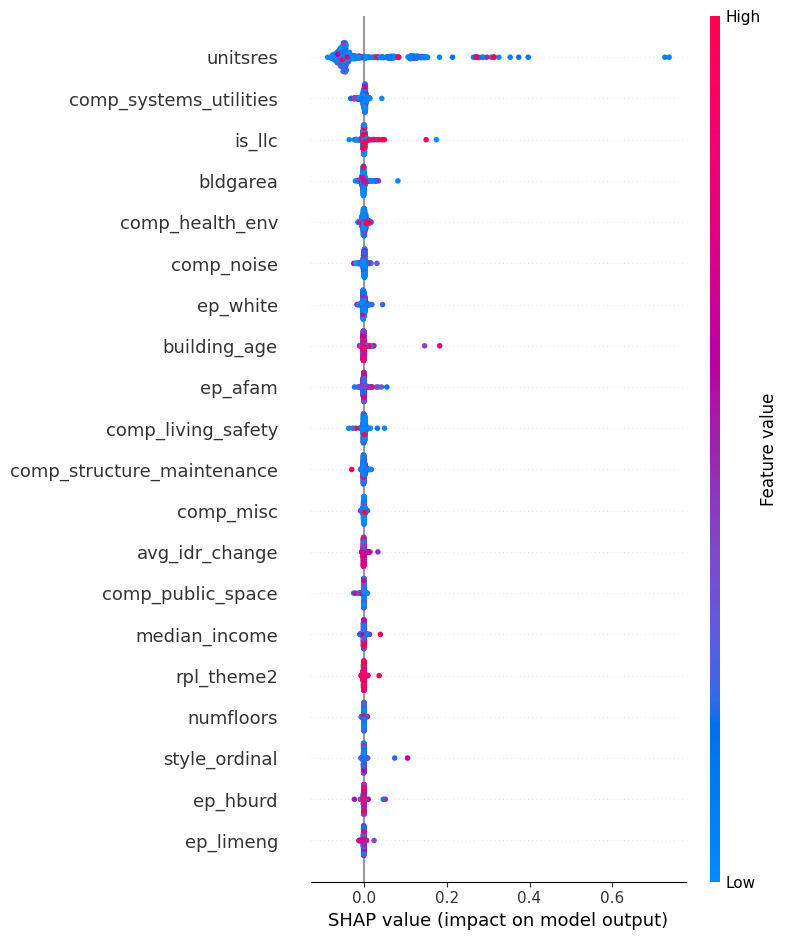

In [46]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_svi.predict, X)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

In [47]:
# shap_values

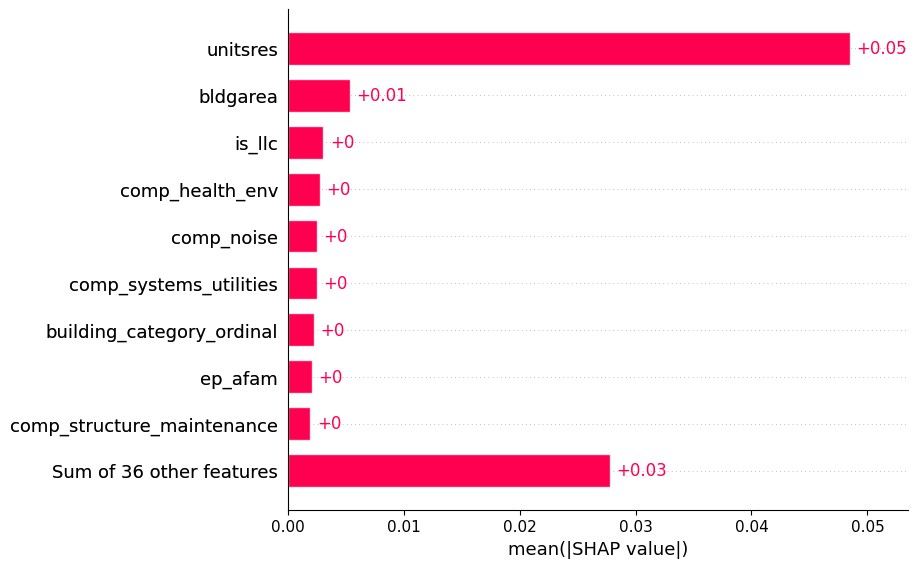

In [48]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.bar(shap_values)

In [49]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [all_vars[i] for i in top_features_idx]

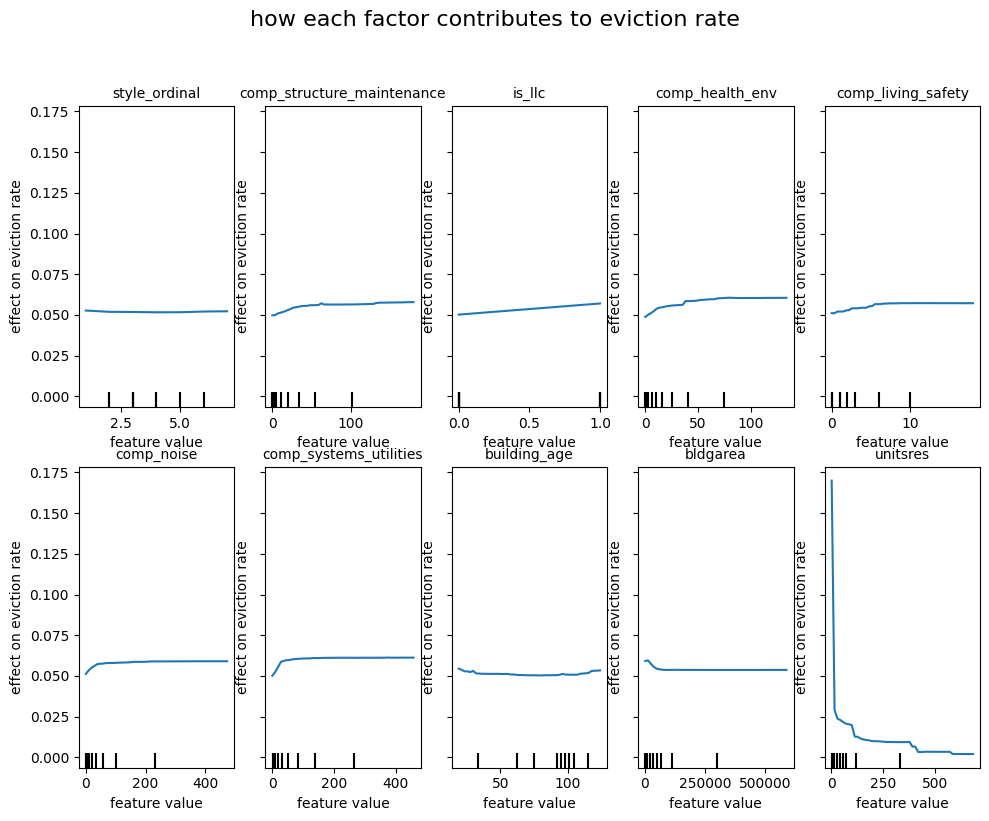

In [50]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

## **Neighborhood Level**

In [51]:
# idr_evi_df_nta = idr_evi_df.drop_duplicates(subset=['Location'])

In [52]:
idr_evi_df.shape

(66395, 147)

In [53]:
X= idr_evi_df[all_vars]
y =idr_evi_df['eviction_count']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [56]:
model_rfr_svi.score(X_test, y_test)

0.9997227068278527

PermutationExplainer explainer: 501it [02:14,  3.44it/s]


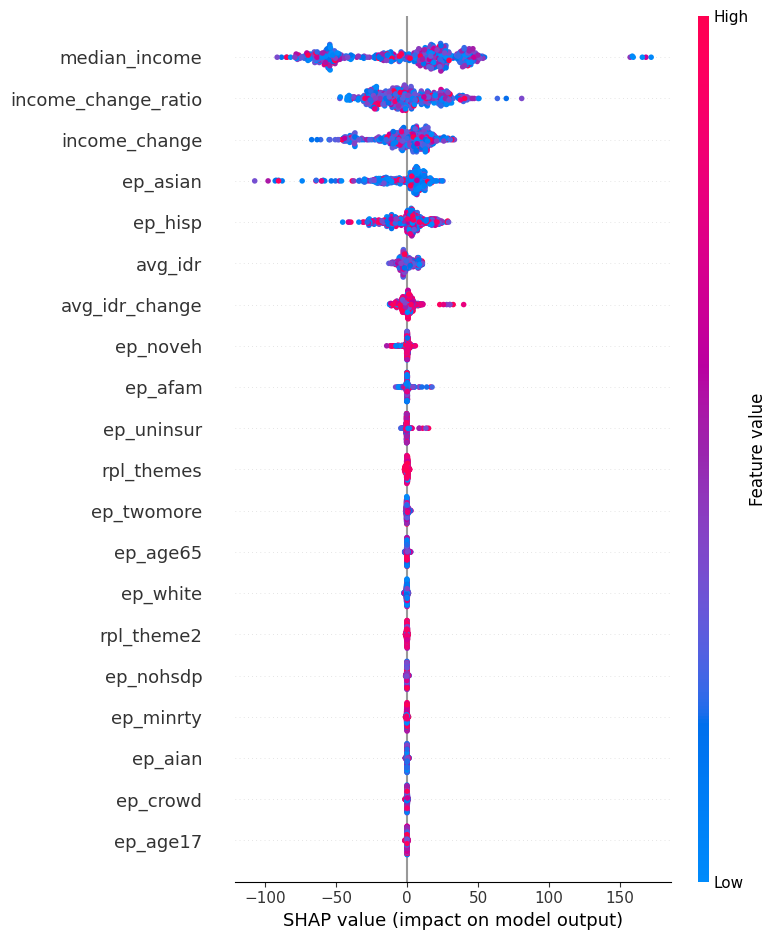

In [57]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_svi.predict, X)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

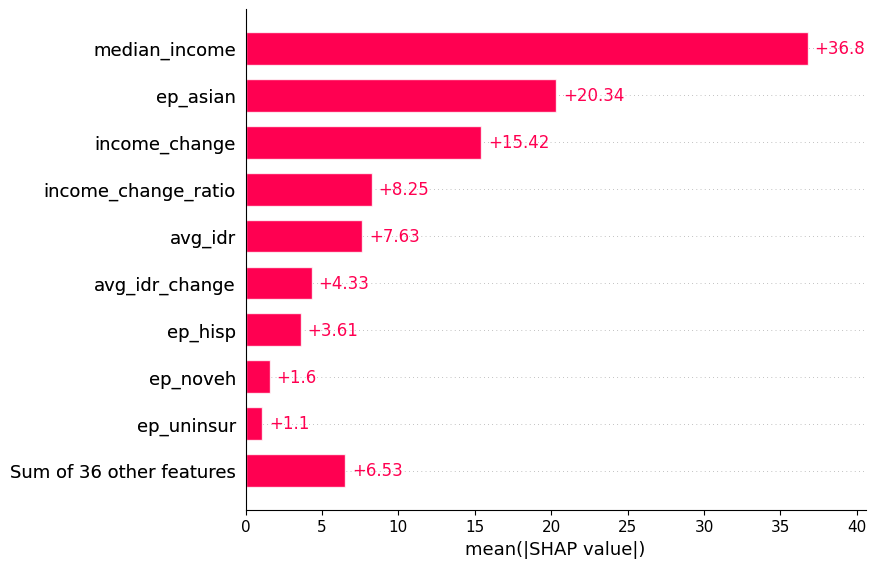

In [58]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.bar(shap_values)

In [59]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [all_vars[i] for i in top_features_idx]

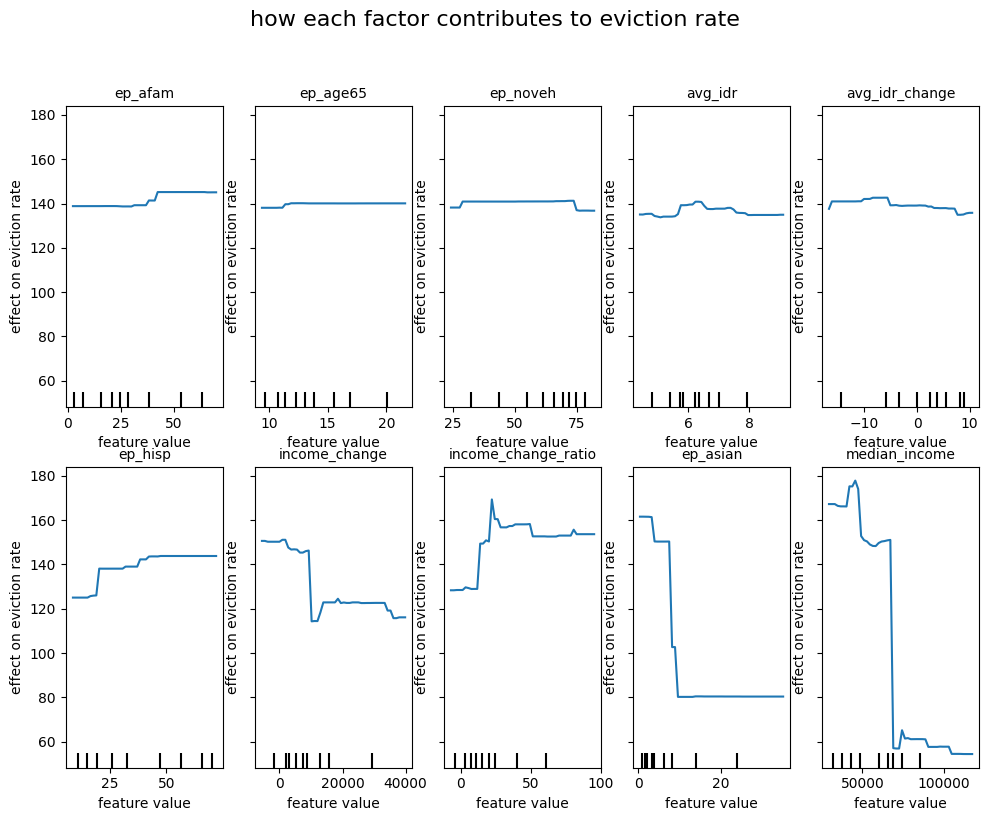

In [60]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

In [61]:
# stop

## **Neighborhood Level**

In [62]:
# idr_evi_df_nta = idr_evi_df.drop_duplicates(subset=['Location'])

In [63]:
# idr_evi_df_nta.shape

In [64]:
# X= idr_evi_df_nta[all_vars]
# y= idr_evi_df_nta['eviction_count']

In [65]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
# model_rfr_svi.fit(X_train, y_train)

In [67]:
# model_rfr_svi.score(X_train, y_train)

In [68]:
# # model.predict instead of model, faster
# explainer = shap.Explainer(model_rfr_svi.predict, X)
# # need to only select the first few hundreds of samples to run
# shap_values = explainer.shap_values(X.sample(n=58))
# shap.summary_plot(shap_values, X.sample(n=58))

In [69]:
# model = xgboost.XGBRegressor()
# model.fit(X, y)

# explainer = shap.Explainer(model)
# shap_values = explainer(X)
# shap.plots.bar(shap_values)
# shap.plots.scatter(shap_values)

## **Zipcode Level**

In [70]:
# idr_evi_df_nta = idr_evi_df.drop_duplicates(subset=['Location'])

In [71]:
# idr_evi_df_zipcode = idr_evi_df.drop_duplicates(subset=['zipcode'])

In [72]:
# idr_evi_df_zipcode.shape

In [73]:
# X= idr_evi_df_zipcode[all_vars]
# y= idr_evi_df_zipcode['eviction_count']

In [74]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
# model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
# model_rfr_svi.fit(X_train, y_train)

In [76]:
# model_rfr_svi.score(X_train, y_train)

In [77]:
# # model.predict instead of model, faster
# explainer = shap.Explainer(model_rfr_svi.predict, X)
# # need to only select the first few hundreds of samples to run
# shap_values = explainer.shap_values(X.sample(n=174))
# shap.summary_plot(shap_values, X.sample(n=174))

In [78]:
# import xgboost, shap

# model = xgboost.XGBRegressor()
# model.fit(X, y)

# explainer = shap.Explainer(model)
# shap_values = explainer(X)
# shap.plots.bar(shap_values)
# shap.plots.scatter(shap_values)

## **Zipcode_Level_full**

In [79]:
idr_evi_df.shape

(66395, 147)

In [80]:
X= idr_evi_df[all_vars]
y= idr_evi_df['average_year_eviction_count_per_zipcode(z)']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [83]:
model_rfr_svi.score(X_test, y_test)

0.9999972933018259

In [ ]:
explainer = shap.Explainer(model_rfr_svi.predict, X)
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

PermutationExplainer explainer:  27%|██▋       | 134/500 [00:37<01:28,  4.13it/s]

In [ ]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.bar(shap_values)

In [ ]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [all_vars[i] for i in top_features_idx]

In [ ]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

## **Building Level (full)**

In [ ]:
# idr_evi_df_nta = idr_evi_df.drop_duplicates(subset=['Location'])

In [ ]:
# idr_evi_df_zipcode = idr_evi_df.drop_duplicates(subset=['zipcode'])

In [ ]:
idr_evi_df.shape

In [ ]:
X= idr_evi_df[all_vars]
y= idr_evi_df['average_year_eviction_count(building)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train, y_train)

In [ ]:
model_rfr_svi.score(X_test, y_test)

In [ ]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_svi.predict, X)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X.sample(n=500))
shap.summary_plot(shap_values, X.sample(n=500))

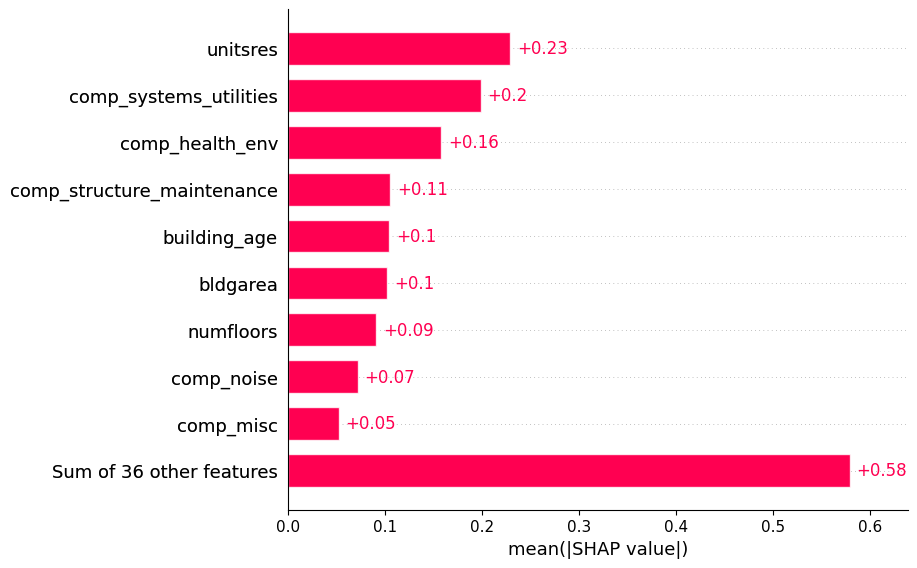

In [96]:
model = xgboost.XGBRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.bar(shap_values)

In [97]:
top_features_idx = np.argsort(model_rfr_svi.feature_importances_)[-10:]
top_features = [all_vars[i] for i in top_features_idx]

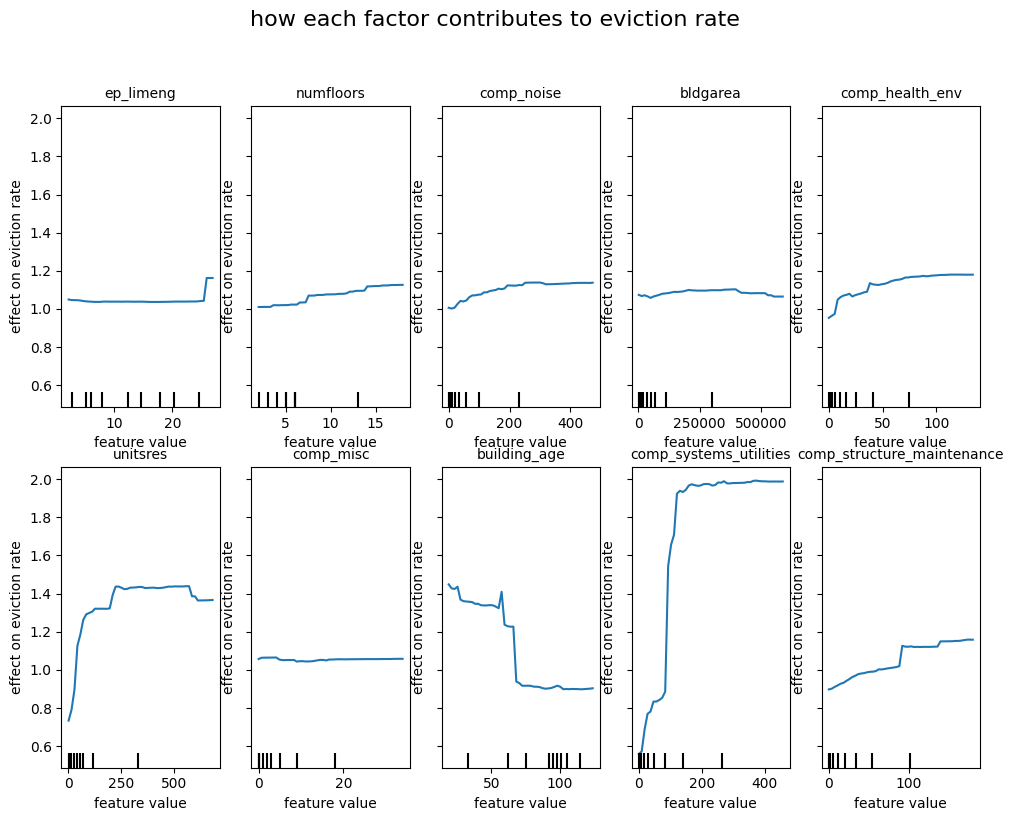

In [98]:
display = PartialDependenceDisplay.from_estimator(
    model_rfr_svi,
    X,
    features=top_features,
    kind='average',
    grid_resolution=50,
    n_cols=5,
)

plt.gcf().set_size_inches(10, 8)
plt.suptitle('how each factor contributes to eviction rate', fontsize=16, y=1.02)
for ax, feature_name in zip(display.axes_.ravel(), top_features):
    ax.set_title(feature_name, fontsize=10)
    ax.set_xlabel('feature value')
    ax.set_ylabel('effect on eviction rate')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
# see below

In [99]:
# shap.dependence_plot(
#     "ep_asian",
#     shap_values,
#     X_test,
#     feature_names=X_test.columns,
#     interaction_index="auto"
# )

# **correlation test**

In [100]:
# idr_evi_df[all_vars]

In [101]:
# idr_evi_df.rename(columns= {'mediaon_income': 'median_income'})
# idr_evi_df.rename(columns = {'mediaon_income': 'median_income'})

In [102]:
len(all_vars)

45

In [103]:
idr_evi_df['median_income'] = idr_evi_df['median_income']*(-1)

In [104]:
df_spearman = idr_evi_df[['average_year_eviction_count(building)'] + all_vars]
# corret way to combine columns, saving space

corr_matrix = df_spearman.corr(method='spearman')

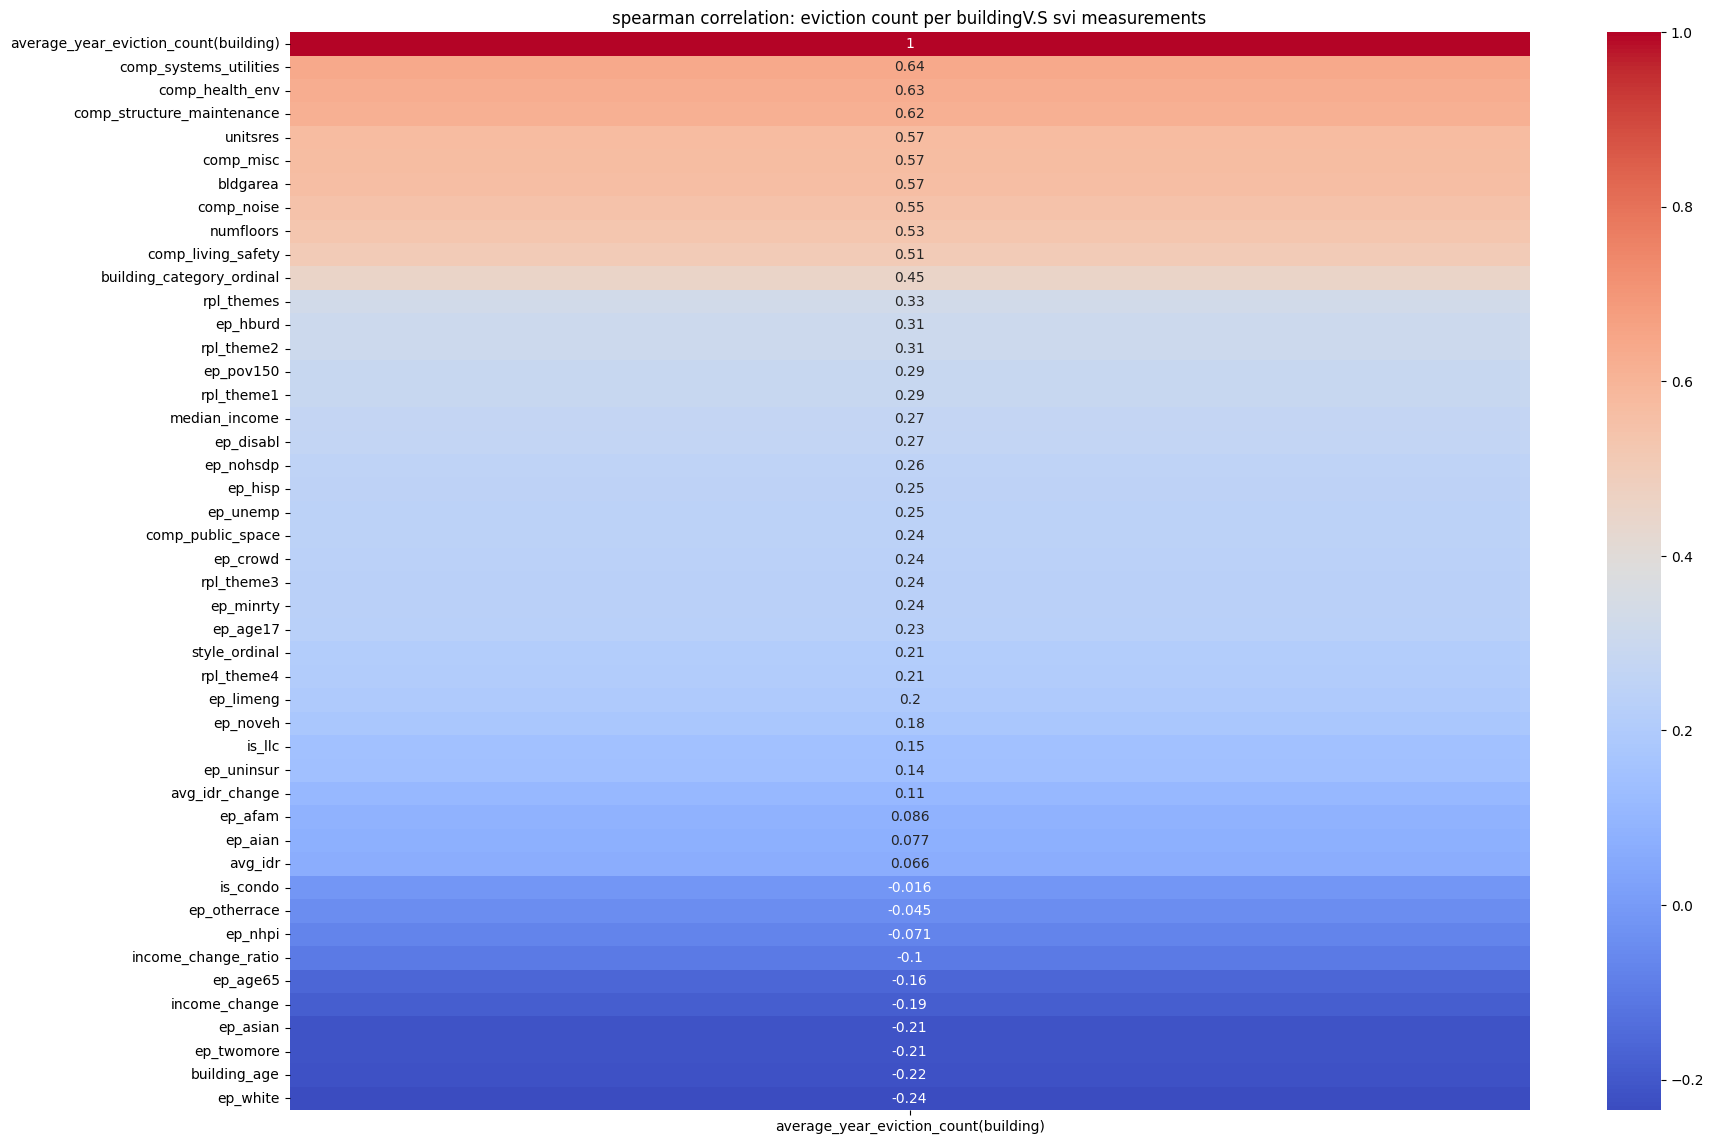

In [105]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['average_year_eviction_count(building)']].sort_values(by='average_year_eviction_count(building)', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per buildingV.S svi measurements')
plt.show()

In [106]:
# corr_matrix[['average_year_eviction_count(building)']]

In [107]:
df_spearman = idr_evi_df[['average_year_eviction_count_per_zipcode(z)'] + all_vars]
# corret way to combine columns, saving space

corr_matrix = df_spearman.corr(method='spearman')

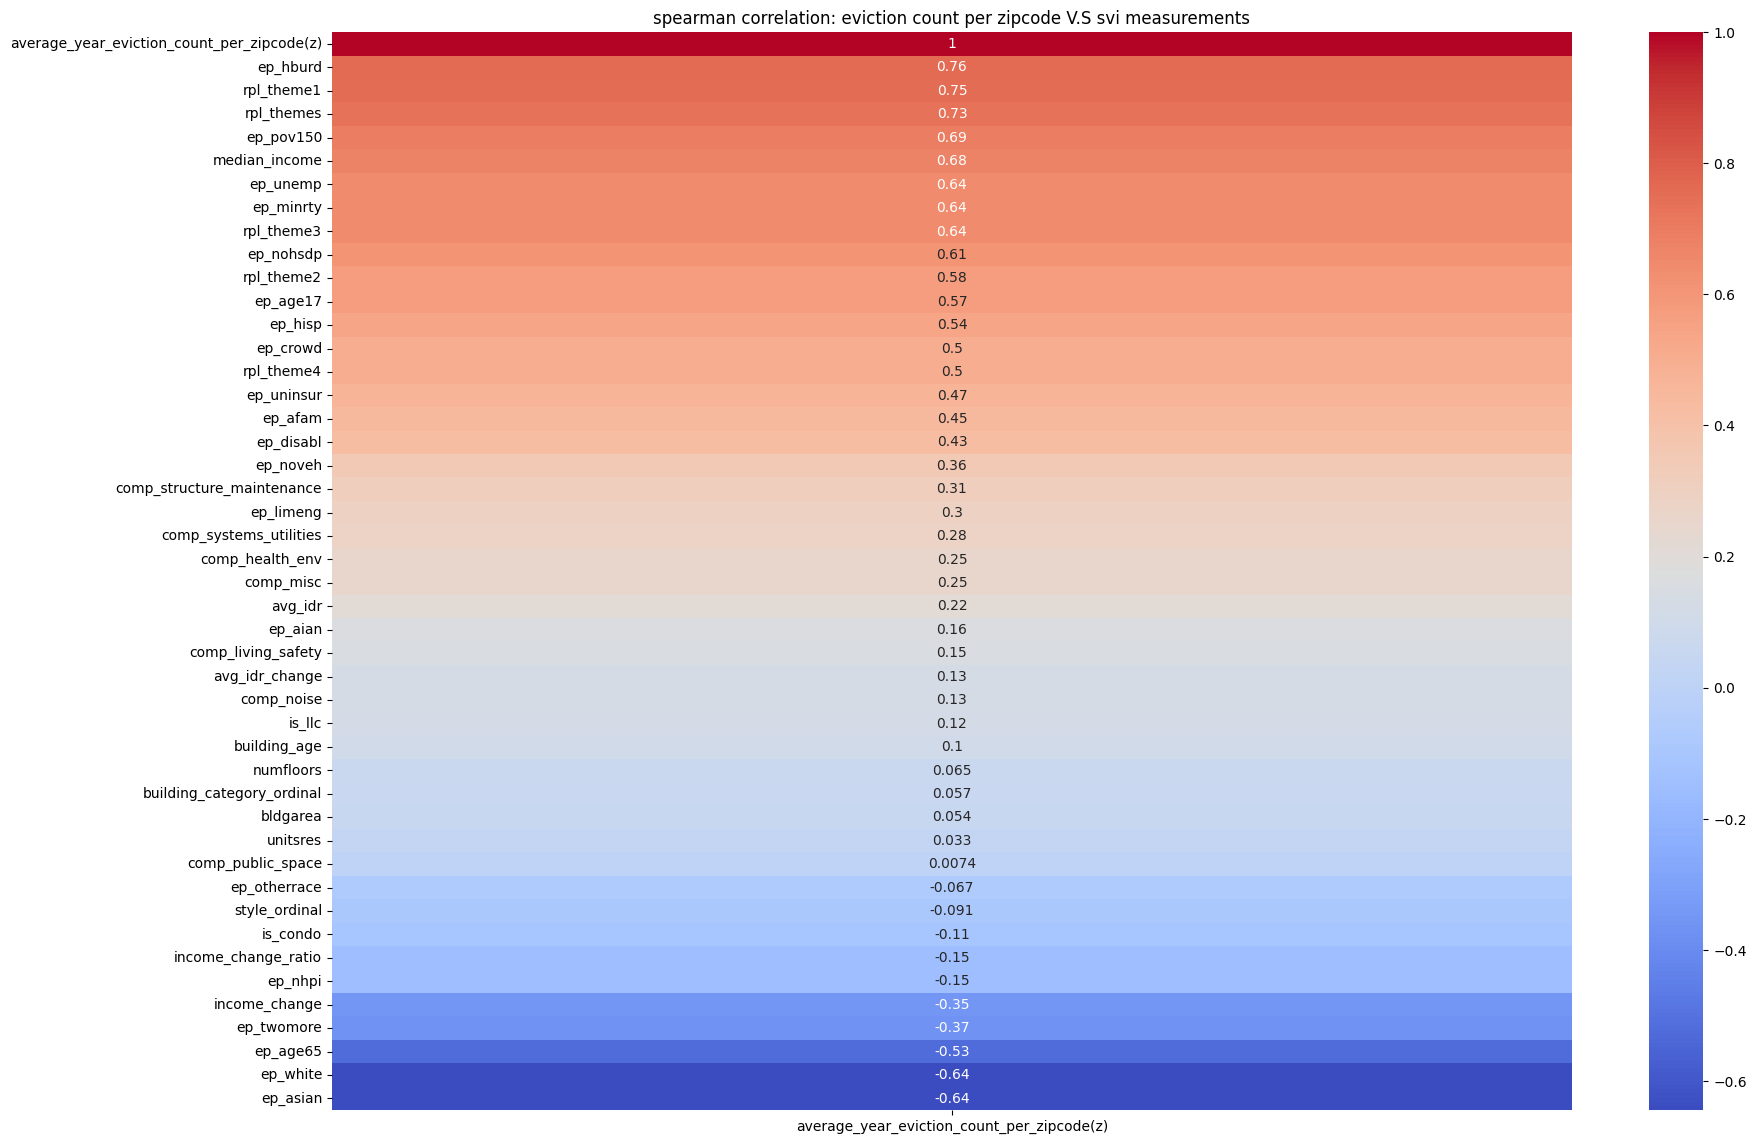

In [108]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['average_year_eviction_count_per_zipcode(z)']].sort_values(by='average_year_eviction_count_per_zipcode(z)', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per zipcode V.S svi measurements')
plt.show()

In [109]:
df_spearman = idr_evi_df[['eviction_count'] + all_vars]
# corret way to combine columns, saving space

corr_matrix = df_spearman.corr(method='spearman')

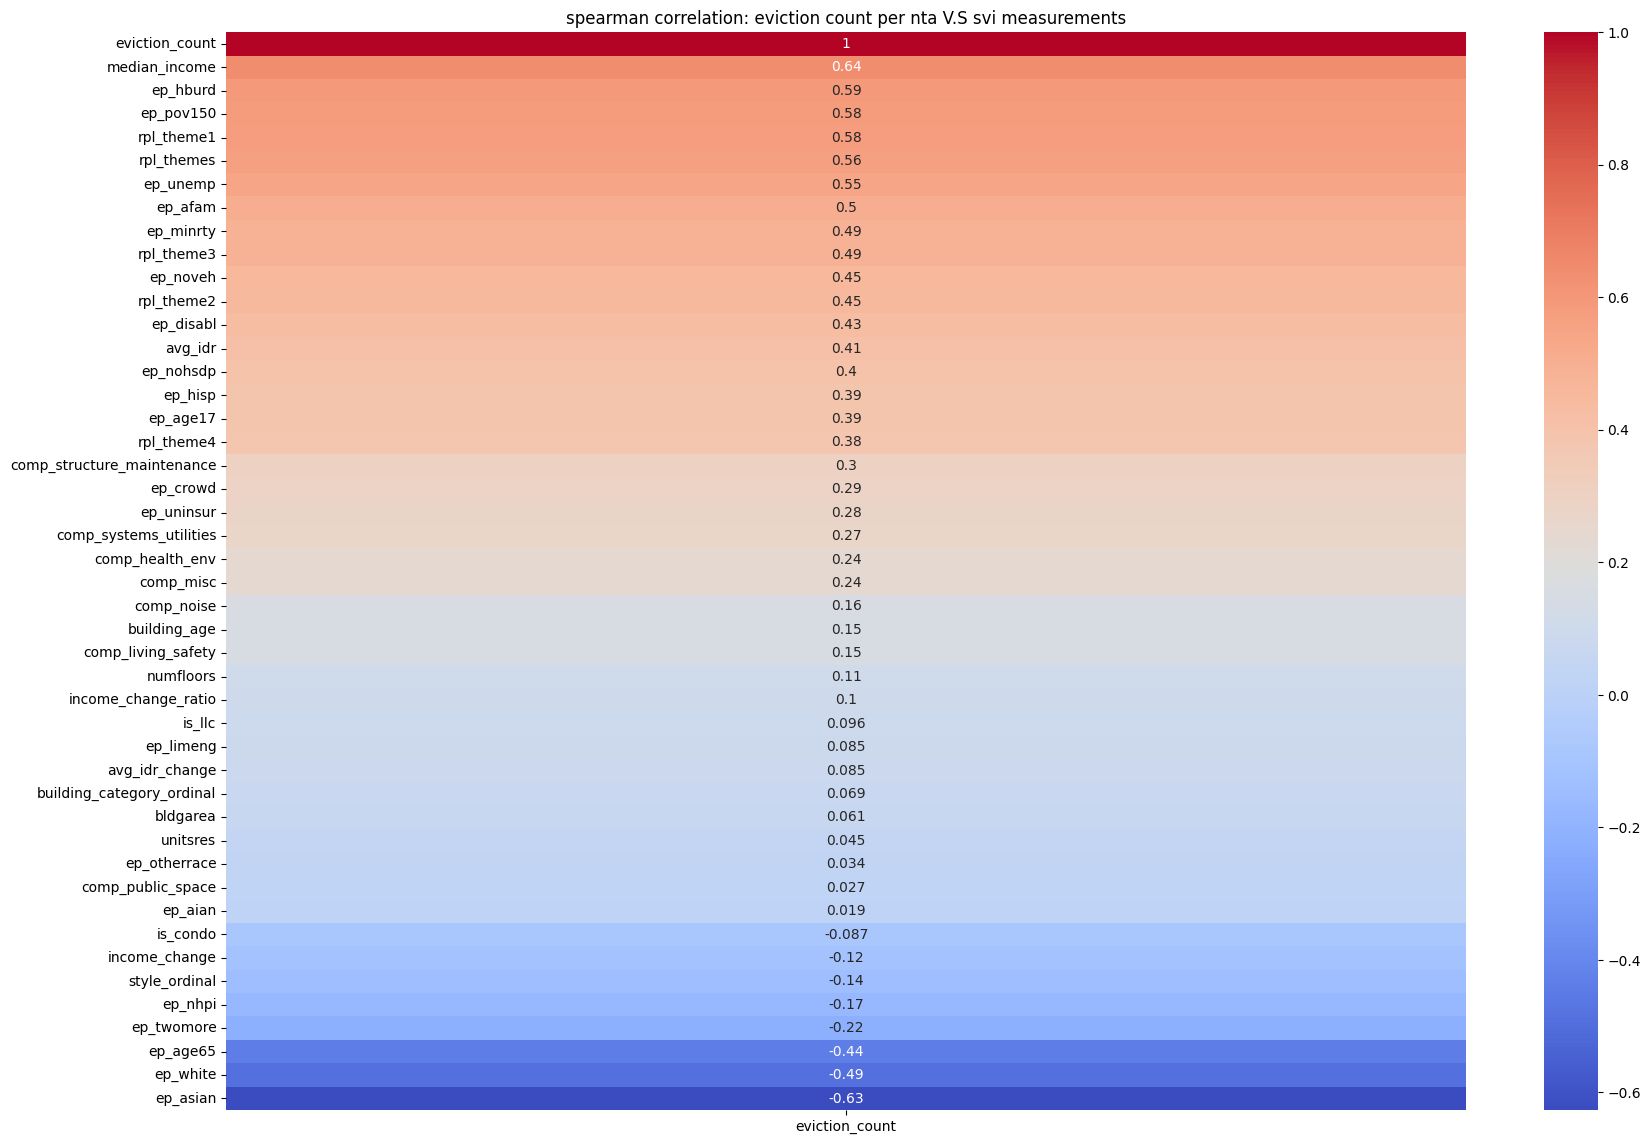

In [110]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['eviction_count']].sort_values(by='eviction_count', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per nta V.S svi measurements')
plt.show()

In [111]:
# average_year_eviction_count_per_unit(building)

In [112]:
df_spearman = idr_evi_df[['average_year_eviction_count_per_unit(building)'] + all_vars]
# corret way to combine columns, saving space

corr_matrix = df_spearman.corr(method='spearman')

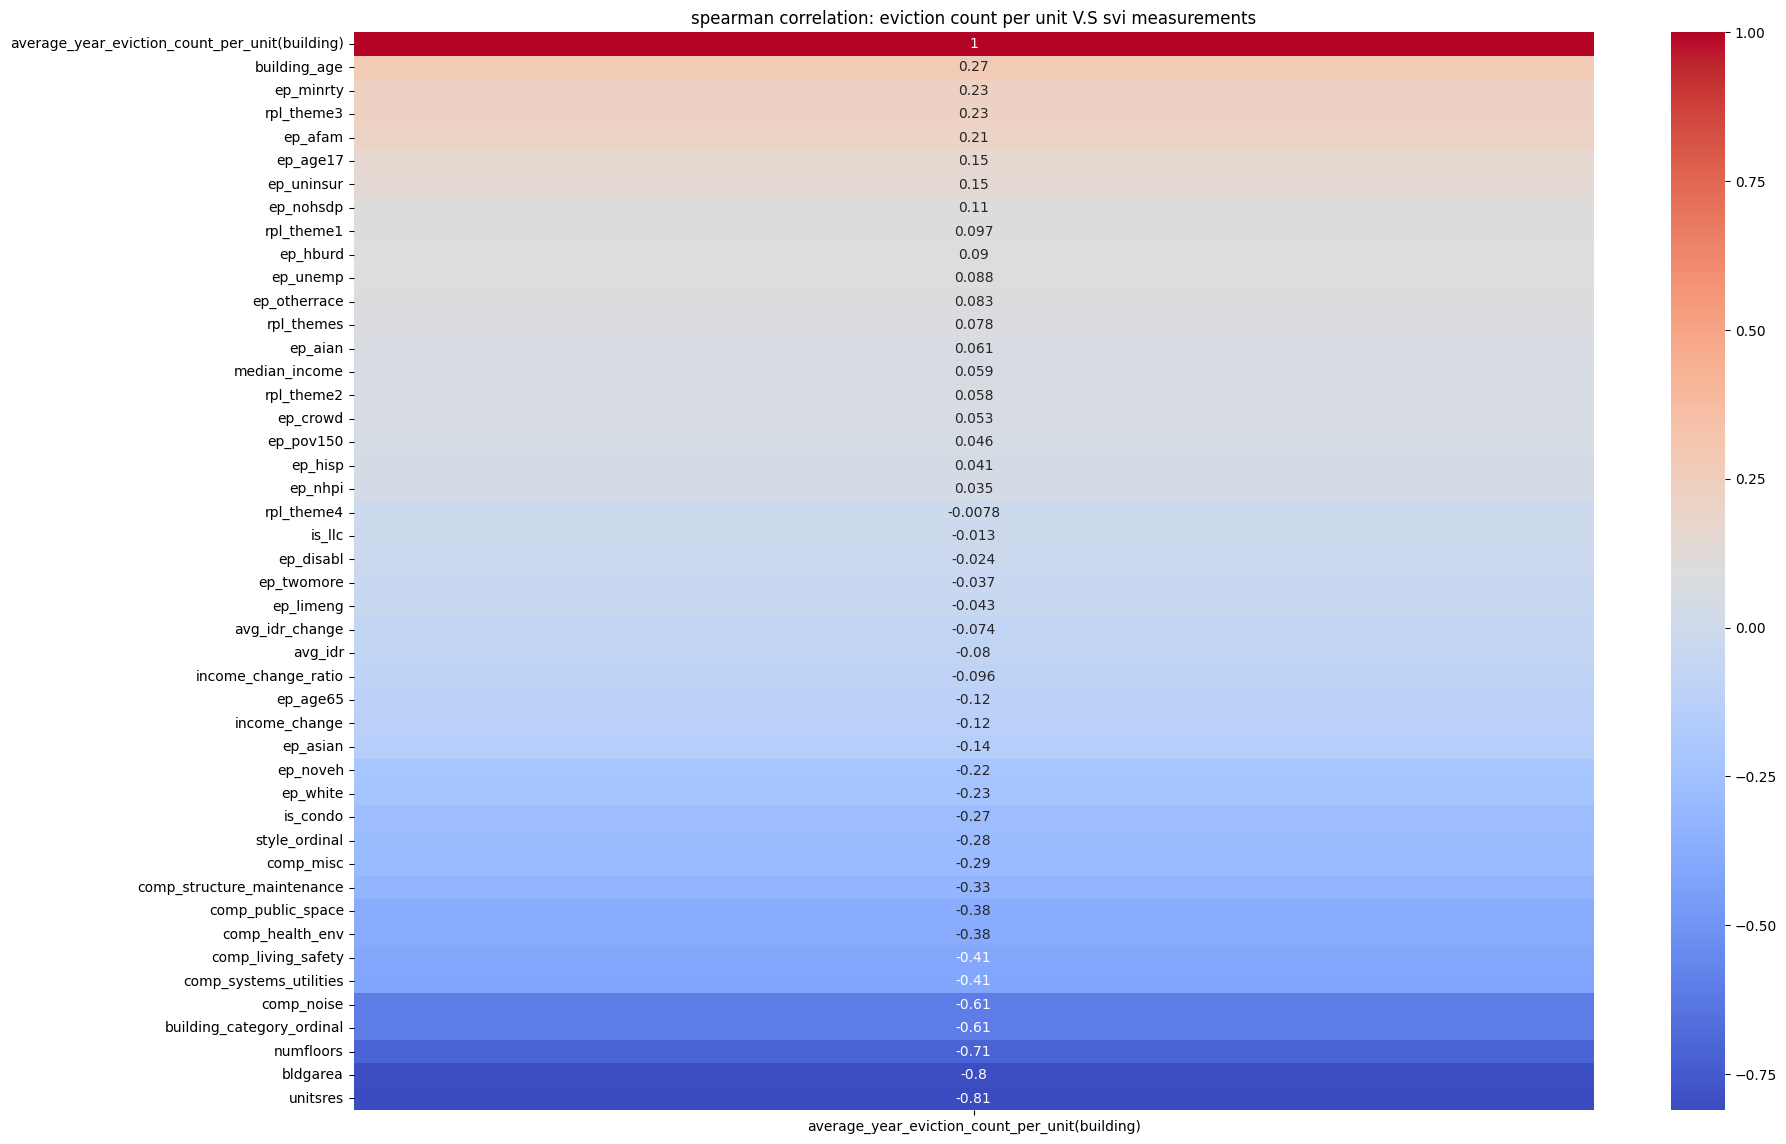

In [113]:
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix[['average_year_eviction_count_per_unit(building)']].sort_values(by='average_year_eviction_count_per_unit(building)', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('spearman correlation: eviction count per unit V.S svi measurements')
plt.show()